<a href="https://colab.research.google.com/github/dfukagaw28/ColabNotebooks/blob/pose_detection/MoveNet%E3%81%A7%E5%8B%95%E7%94%BB%E3%81%AEkeypoint%E3%82%92%E5%8F%96%E5%BE%97%E3%81%99%E3%82%8B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MoveNetで転倒検知

## 1: 準備

In [ ]:
# @title Google Drive をマウントする
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from pathlib import Path

In [ ]:
DATADIR_BASE = Path('/content/drive/MyDrive/data')

In [ ]:
# @title パッケージを読み込む

from pathlib import Path
# from urllib.parse import urlparse
import warnings

import cv2
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.patches as patches
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub


# import tensorflow_hub as hub
# from tensorflow_docs.vis import embed
# import numpy as np
# import cv2

# # Import matplotlib libraries
# from matplotlib import pyplot as plt
# import matplotlib.patches as patches

# # Some modules to display an animation using imageio.
# import imageio
# from IPython.display import HTML, display

In [ ]:
# @title helper functions

# Dictionary that maps from joint names to keypoint indices.
KEYPOINT_DICT = {
    'nose': 0,
    'left_eye': 1,
    'right_eye': 2,
    'left_ear': 3,
    'right_ear': 4,
    'left_shoulder': 5,
    'right_shoulder': 6,
    'left_elbow': 7,
    'right_elbow': 8,
    'left_wrist': 9,
    'right_wrist': 10,
    'left_hip': 11,
    'right_hip': 12,
    'left_knee': 13,
    'right_knee': 14,
    'left_ankle': 15,
    'right_ankle': 16
}

# Maps bones to a matplotlib color name.
KEYPOINT_EDGE_INDS_TO_COLOR = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}


def _keypoints_and_edges_for_display(keypoints_with_scores,
                                     height,
                                     width,
                                     keypoint_threshold=0.11):
  """Returns high confidence keypoints and edges for visualization.

  Args:
    keypoints_with_scores: A numpy array with shape [1, 1, 17, 3] representing
      the keypoint coordinates and scores returned from the MoveNet model.
    height: height of the image in pixels.
    width: width of the image in pixels.
    keypoint_threshold: minimum confidence score for a keypoint to be
      visualized.

  Returns:
    A (keypoints_xy, edges_xy, edge_colors) containing:
      * the coordinates of all keypoints of all detected entities;
      * the coordinates of all skeleton edges of all detected entities;
      * the colors in which the edges should be plotted.
  """
  keypoints_all = []
  keypoint_edges_all = []
  edge_colors = []
  num_instances, _, _, _ = keypoints_with_scores.shape
  for idx in range(num_instances):
    kpts_x = keypoints_with_scores[0, idx, :, 1]
    kpts_y = keypoints_with_scores[0, idx, :, 0]
    kpts_scores = keypoints_with_scores[0, idx, :, 2]
    kpts_absolute_xy = np.stack(
        [width * np.array(kpts_x), height * np.array(kpts_y)], axis=-1)
    kpts_above_thresh_absolute = kpts_absolute_xy[
        kpts_scores > keypoint_threshold, :]
    keypoints_all.append(kpts_above_thresh_absolute)

    for edge_pair, color in KEYPOINT_EDGE_INDS_TO_COLOR.items():
      if (kpts_scores[edge_pair[0]] > keypoint_threshold and
          kpts_scores[edge_pair[1]] > keypoint_threshold):
        x_start = kpts_absolute_xy[edge_pair[0], 0]
        y_start = kpts_absolute_xy[edge_pair[0], 1]
        x_end = kpts_absolute_xy[edge_pair[1], 0]
        y_end = kpts_absolute_xy[edge_pair[1], 1]
        line_seg = np.array([[x_start, y_start], [x_end, y_end]])
        keypoint_edges_all.append(line_seg)
        edge_colors.append(color)
  if keypoints_all:
    keypoints_xy = np.concatenate(keypoints_all, axis=0)
  else:
    keypoints_xy = np.zeros((0, 17, 2))

  if keypoint_edges_all:
    edges_xy = np.stack(keypoint_edges_all, axis=0)
  else:
    edges_xy = np.zeros((0, 2, 2))
  return keypoints_xy, edges_xy, edge_colors


def draw_prediction_on_image(
    image, keypoints_with_scores, crop_region=None, close_figure=False,
    output_image_height=None):
  """Draws the keypoint predictions on image.

  Args:
    image: A numpy array with shape [height, width, channel] representing the
      pixel values of the input image.
    keypoints_with_scores: A numpy array with shape [1, 1, 17, 3] representing
      the keypoint coordinates and scores returned from the MoveNet model.
    crop_region: A dictionary that defines the coordinates of the bounding box
      of the crop region in normalized coordinates (see the init_crop_region
      function below for more detail). If provided, this function will also
      draw the bounding box on the image.
    output_image_height: An integer indicating the height of the output image.
      Note that the image aspect ratio will be the same as the input image.

  Returns:
    A numpy array with shape [out_height, out_width, channel] representing the
    image overlaid with keypoint predictions.
  """
  height, width, channel = image.shape
  aspect_ratio = float(width) / height
  fig, ax = plt.subplots(figsize=(12 * aspect_ratio, 12))
  # To remove the huge white borders
  fig.tight_layout(pad=0)
  ax.margins(0)
  ax.set_yticklabels([])
  ax.set_xticklabels([])
  plt.axis('off')

  im = ax.imshow(image)
  line_segments = LineCollection([], linewidths=(4), linestyle='solid')
  ax.add_collection(line_segments)
  # Turn off tick labels
  scat = ax.scatter([], [], s=60, color='#FF1493', zorder=3)

  (keypoint_locs, keypoint_edges,
   edge_colors) = _keypoints_and_edges_for_display(
       keypoints_with_scores, height, width)

  line_segments.set_segments(keypoint_edges)
  line_segments.set_color(edge_colors)
  if keypoint_edges.shape[0]:
    line_segments.set_segments(keypoint_edges)
    line_segments.set_color(edge_colors)
  if keypoint_locs.shape[0]:
    scat.set_offsets(keypoint_locs)

  if crop_region is not None:
    xmin = max(crop_region['x_min'] * width, 0.0)
    ymin = max(crop_region['y_min'] * height, 0.0)
    rec_width = min(crop_region['x_max'], 0.99) * width - xmin
    rec_height = min(crop_region['y_max'], 0.99) * height - ymin
    rect = patches.Rectangle(
        (xmin,ymin),rec_width,rec_height,
        linewidth=1,edgecolor='b',facecolor='none')
    ax.add_patch(rect)

  fig.canvas.draw()
  with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=DeprecationWarning)
    image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    image_from_plot = image_from_plot.reshape(
        fig.canvas.get_width_height()[::-1] + (3,))
  plt.close(fig)
  if output_image_height is not None:
    output_image_width = int(output_image_height / height * width)
    image_from_plot = cv2.resize(
        image_from_plot, dsize=(output_image_width, output_image_height),
         interpolation=cv2.INTER_CUBIC)
  return image_from_plot

In [ ]:
#@title 画像からキーポイントを求める関数を定義する

def get_keypoints(image):
  # Resize and pad the image to keep the aspect ratio and fit the expected size.
  input_image = tf.expand_dims(image, axis=0)
  input_image = tf.image.resize_with_pad(input_image, input_size, input_size)

  # Run model inference.
  keypoints_with_scores = movenet(input_image)

  return keypoints_with_scores

In [ ]:
#@title 画像シーケンスからキーポイントの列を求める関数を定義する

def get_keypoints_seq(image_dir):
  image_dir = Path(image_dir)
  image_paths = sorted(image_dir.glob('*.png'))

  print(len(image_paths), 'images')

  keypoints_sequence = []

  for image_path in image_paths:
    image = tf.io.read_file(str(image_path))
    image = tf.image.decode_jpeg(image)

    keypoints_with_scores = get_keypoints(image)

    keypoints_sequence.append(keypoints_with_scores)

  return keypoints_sequence

## 2: モデルを読み込む

In [ ]:
# @title TF hub からモデルを読み込む

module = hub.load("https://tfhub.dev/google/movenet/singlepose/thunder/4")
input_size = 256

def movenet(input_image):
  model = module.signatures['serving_default']

  # SavedModel format expects tensor type of int32.
  input_image = tf.cast(input_image, dtype=tf.int32)
  # Run model inference.
  outputs = model(input_image)
  # Output is a [1, 1, 17, 3] tensor.
  keypoints_with_scores = outputs['output_0'].numpy()

  return keypoints_with_scores

## 3: データを読み込む

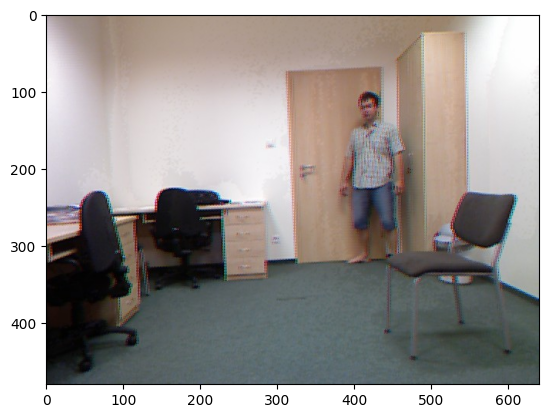

In [ ]:
# @title 画像を読み込む
datadir = DATADIR_BASE / 'URFD' / 'Fall'
image_path = datadir / 'fall-01-cam0-rgb' / 'fall-01-cam0-rgb-001.png'
image = tf.io.read_file(str(image_path))
image = tf.image.decode_png(image)

plt.imshow(image)
plt.show()

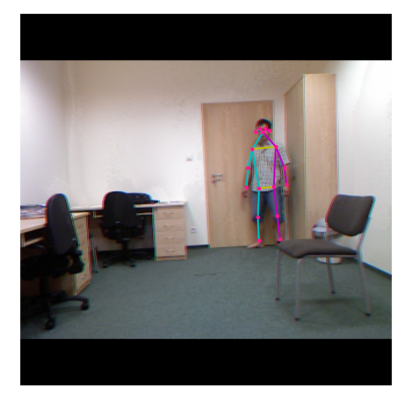

In [ ]:
# @title 推論を実行する

# Resize and pad the image to keep the aspect ratio and fit the expected size.
input_image = tf.expand_dims(image, axis=0)
input_image = tf.image.resize_with_pad(input_image, input_size, input_size)

# Run model inference.
keypoints_with_scores = movenet(input_image)

# Visualize the predictions with image.
display_image = tf.expand_dims(image, axis=0)
display_image = tf.cast(tf.image.resize_with_pad(
    display_image, 1280, 1280), dtype=tf.int32)
output_overlay = draw_prediction_on_image(
    np.squeeze(display_image.numpy(), axis=0), keypoints_with_scores)

plt.figure(figsize=(5, 5))
plt.imshow(output_overlay)
_ = plt.axis('off')

In [ ]:
#@title 画像の列からキーポイントの列を求める

datadir = DATADIR_BASE / 'URFD' / 'Fall'
image_dir = datadir / 'fall-01-cam0-rgb'
keypoints_sequence = get_keypoints_seq(image_dir)

keypoints_sequence = tf.convert_to_tensor(keypoints_sequence)

keypoints_sequence = tf.reshape(keypoints_sequence, shape=(-1, 17 * 3))

160 images


In [ ]:
df = pd.DataFrame(keypoints_sequence.numpy())
df.to_csv('URFD_fall-01-cam0-rgb.csv')

In [ ]:
#@title 画像の列からキーポイントの列を求める

datadir = DATADIR_BASE / 'URFD' / 'Fall'
image_dir = datadir / 'fall-30-cam0-rgb'
keypoints_sequence = get_keypoints_seq(image_dir)

keypoints_sequence = tf.convert_to_tensor(keypoints_sequence)

keypoints_sequence = tf.reshape(keypoints_sequence, shape=(-1, 17 * 3))

df = pd.DataFrame(keypoints_sequence.numpy())
df.to_csv('URFD_fall-30-cam0-rgb.csv')

70 images


In [ ]:
# columns = KEYPOINT_DICT

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,0.318372,0.653793,0.563310,0.308723,0.659514,0.651985,0.309975,0.645336,0.600861,0.313684,...,0.570717,0.547338,0.639811,0.444083,0.607128,0.699487,0.339129,0.610041,0.642454,0.510997
1,0.318231,0.651234,0.604747,0.308684,0.656797,0.605554,0.309729,0.643121,0.565992,0.313279,...,0.579309,0.544037,0.643867,0.388471,0.608455,0.699372,0.343948,0.611973,0.642802,0.573335
2,0.317606,0.651063,0.580723,0.308988,0.656892,0.591719,0.309291,0.642632,0.565709,0.313482,...,0.590312,0.549073,0.639365,0.415889,0.608144,0.701466,0.364555,0.611588,0.640366,0.549429
3,0.317584,0.645076,0.567680,0.307855,0.651521,0.599581,0.309848,0.638051,0.522953,0.312719,...,0.589734,0.547547,0.637987,0.476798,0.606769,0.696855,0.297518,0.611219,0.637288,0.548312
4,0.316848,0.643832,0.502783,0.307342,0.650100,0.658000,0.308482,0.636567,0.617292,0.312340,...,0.560122,0.547196,0.640945,0.427593,0.607791,0.700370,0.369731,0.610295,0.641543,0.535590
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,0.803994,0.454516,0.145531,0.803607,0.453073,0.170062,0.802659,0.468049,0.113593,0.824527,...,0.144786,0.771619,0.439095,0.125915,0.863712,0.383956,0.164089,0.827105,0.491309,0.048380
156,0.804134,0.453720,0.144240,0.814290,0.452750,0.158920,0.801251,0.466642,0.131837,0.822521,...,0.149470,0.788793,0.454158,0.103156,0.847305,0.424062,0.076347,0.824843,0.490087,0.057281
157,0.819164,0.448898,0.066505,0.827510,0.440984,0.143384,0.818203,0.452336,0.064843,0.819235,...,0.148717,0.787288,0.438048,0.088600,0.827083,0.424819,0.042892,0.749405,0.405002,0.152699
158,0.819823,0.445479,0.065887,0.818654,0.444598,0.083163,0.816436,0.448573,0.094285,0.818509,...,0.115868,0.787675,0.436202,0.092131,0.865463,0.386431,0.134674,0.837078,0.489756,0.035564


<tf.Tensor: shape=(160, 17, 3), dtype=float32, numpy=
array([[[0.31837216, 0.65379286, 0.56330967],
        [0.30872303, 0.65951365, 0.6519853 ],
        [0.30997476, 0.6453358 , 0.6008609 ],
        ...,
        [0.54733783, 0.63981134, 0.44408315],
        [0.60712814, 0.6994871 , 0.33912894],
        [0.6100408 , 0.64245355, 0.5109971 ]],

       [[0.31823066, 0.6512343 , 0.6047468 ],
        [0.3086835 , 0.65679735, 0.6055539 ],
        [0.30972904, 0.6431215 , 0.56599224],
        ...,
        [0.5440372 , 0.6438668 , 0.3884712 ],
        [0.6084546 , 0.699372  , 0.34394804],
        [0.61197263, 0.6428019 , 0.5733352 ]],

       [[0.31760573, 0.6510631 , 0.58072305],
        [0.30898756, 0.6568919 , 0.5917194 ],
        [0.30929118, 0.6426319 , 0.5657092 ],
        ...,
        [0.5490725 , 0.6393655 , 0.41588917],
        [0.6081437 , 0.7014658 , 0.36455533],
        [0.6115884 , 0.64036566, 0.54942936]],

       ...,

       [[0.81916404, 0.44889817, 0.06650545],
        [0.827

<tf.Tensor: shape=(160, 1, 1, 17, 3), dtype=float32, numpy=
array([[[[[0.31837216, 0.65379286, 0.56330967],
          [0.30872303, 0.65951365, 0.6519853 ],
          [0.30997476, 0.6453358 , 0.6008609 ],
          ...,
          [0.54733783, 0.63981134, 0.44408315],
          [0.60712814, 0.6994871 , 0.33912894],
          [0.6100408 , 0.64245355, 0.5109971 ]]]],



       [[[[0.31823066, 0.6512343 , 0.6047468 ],
          [0.3086835 , 0.65679735, 0.6055539 ],
          [0.30972904, 0.6431215 , 0.56599224],
          ...,
          [0.5440372 , 0.6438668 , 0.3884712 ],
          [0.6084546 , 0.699372  , 0.34394804],
          [0.61197263, 0.6428019 , 0.5733352 ]]]],



       [[[[0.31760573, 0.6510631 , 0.58072305],
          [0.30898756, 0.6568919 , 0.5917194 ],
          [0.30929118, 0.6426319 , 0.5657092 ],
          ...,
          [0.5490725 , 0.6393655 , 0.41588917],
          [0.6081437 , 0.7014658 , 0.36455533],
          [0.6115884 , 0.64036566, 0.54942936]]]],



       ...,



In [ ]:
get_keypoints_with_scores(image).shape

(1, 1, 17, 3)

In [ ]:
# @title 画像シーケンスを読み込んでキーポイントの列を求める

datadir = DATADIR_BASE / 'URFD' / 'Fall'
image_paths = sorted((datadir / 'fall-01-cam0-rgb').glob('fall-01-cam0-rgb-*.png'))
print(len(image_paths))

160


PosixPath('/content/drive/MyDrive/data/URFD/Fall/fall-01-cam0-rgb/fall-01-cam0-rgb-001.png')

In [ ]:
image_paths

[PosixPath('/content/drive/MyDrive/data/URFD/Fall/fall-01-cam0-rgb/fall-01-cam0-rgb-001.png'),
 PosixPath('/content/drive/MyDrive/data/URFD/Fall/fall-01-cam0-rgb/fall-01-cam0-rgb-002.png'),
 PosixPath('/content/drive/MyDrive/data/URFD/Fall/fall-01-cam0-rgb/fall-01-cam0-rgb-003.png'),
 PosixPath('/content/drive/MyDrive/data/URFD/Fall/fall-01-cam0-rgb/fall-01-cam0-rgb-004.png'),
 PosixPath('/content/drive/MyDrive/data/URFD/Fall/fall-01-cam0-rgb/fall-01-cam0-rgb-005.png'),
 PosixPath('/content/drive/MyDrive/data/URFD/Fall/fall-01-cam0-rgb/fall-01-cam0-rgb-006.png'),
 PosixPath('/content/drive/MyDrive/data/URFD/Fall/fall-01-cam0-rgb/fall-01-cam0-rgb-007.png'),
 PosixPath('/content/drive/MyDrive/data/URFD/Fall/fall-01-cam0-rgb/fall-01-cam0-rgb-008.png'),
 PosixPath('/content/drive/MyDrive/data/URFD/Fall/fall-01-cam0-rgb/fall-01-cam0-rgb-009.png'),
 PosixPath('/content/drive/MyDrive/data/URFD/Fall/fall-01-cam0-rgb/fall-01-cam0-rgb-010.png'),
 PosixPath('/content/drive/MyDrive/data/URFD/Fall/

In [ ]:
input_image = tf.expand_dims(image, axis=0)
input_image = tf.image.resize_with_pad(input_image, input_size, input_size)
input_image

<tf.Tensor: shape=(1, 256, 256, 3), dtype=float32, numpy=
array([[[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        ...,

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]]], dty

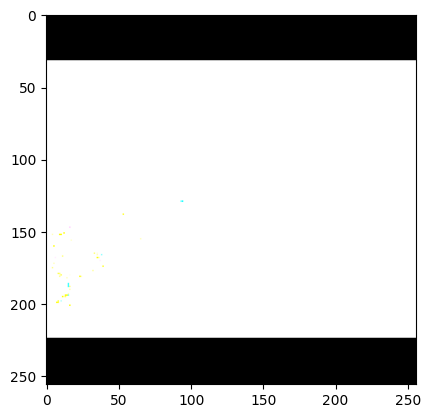

In [ ]:
plt.imshow(input_image[0])
plt.show()

In [ ]:
from urllib.parse import urlparse

image_url = 'https://images.pexels.com/photos/4384679/pexels-photo-4384679.jpeg'  # @param {type:"string"}

assert Path(urlparse(image_url).path).suffix in ('.jpeg', '.jpg')

image_path = 'input_image.jpeg'

!curl -s -o {image_path} {image_url}

image = tf.io.read_file(image_path)
image = tf.image.decode_jpeg(image)

In [ ]:
# @title 推論を実行する

# Resize and pad the image to keep the aspect ratio and fit the expected size.
input_image = tf.expand_dims(image, axis=0)
input_image = tf.image.resize_with_pad(input_image, input_size, input_size)

# Run model inference.
keypoints_with_scores = movenet(input_image)

# Visualize the predictions with image.
display_image = tf.expand_dims(image, axis=0)
display_image = tf.cast(tf.image.resize_with_pad(
    display_image, 1280, 1280), dtype=tf.int32)
output_overlay = draw_prediction_on_image(
    np.squeeze(display_image.numpy(), axis=0), keypoints_with_scores)

plt.figure(figsize=(5, 5))
plt.imshow(output_overlay)
_ = plt.axis('off')

NameError: name 'draw_prediction_on_image' is not defined

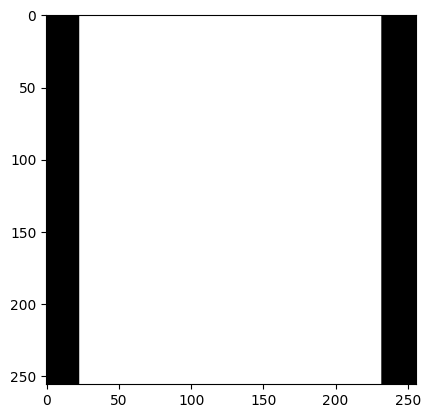

In [ ]:
plt.imshow(input_image[0])
plt.show()

In [ ]:
image.shape

TensorShape([480, 640, 3])

In [ ]:
input_image.shape

TensorShape([1, 256, 256, 3])

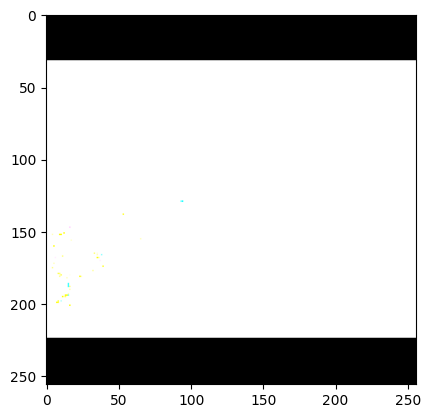

In [ ]:
plt.imshow(input_image[0])
plt.show()

In [ ]:
input_image = tf.expand_dims(image, axis=0)
input_image = tf.image.resize_with_pad(input_image, input_size, input_size)

keypoints_with_scores = movenet(input_image)

<tf.Tensor: shape=(1, 256, 256, 3), dtype=float32, numpy=
array([[[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        ...,

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]]], dty

In [ ]:
!ls {datadir}/fall-01-cam0-rgb

fall-01-cam0-rgb-001.png  fall-01-cam0-rgb-055.png  fall-01-cam0-rgb-109.png
fall-01-cam0-rgb-002.png  fall-01-cam0-rgb-056.png  fall-01-cam0-rgb-110.png
fall-01-cam0-rgb-003.png  fall-01-cam0-rgb-057.png  fall-01-cam0-rgb-111.png
fall-01-cam0-rgb-004.png  fall-01-cam0-rgb-058.png  fall-01-cam0-rgb-112.png
fall-01-cam0-rgb-005.png  fall-01-cam0-rgb-059.png  fall-01-cam0-rgb-113.png
fall-01-cam0-rgb-006.png  fall-01-cam0-rgb-060.png  fall-01-cam0-rgb-114.png
fall-01-cam0-rgb-007.png  fall-01-cam0-rgb-061.png  fall-01-cam0-rgb-115.png
fall-01-cam0-rgb-008.png  fall-01-cam0-rgb-062.png  fall-01-cam0-rgb-116.png
fall-01-cam0-rgb-009.png  fall-01-cam0-rgb-063.png  fall-01-cam0-rgb-117.png
fall-01-cam0-rgb-010.png  fall-01-cam0-rgb-064.png  fall-01-cam0-rgb-118.png
fall-01-cam0-rgb-011.png  fall-01-cam0-rgb-065.png  fall-01-cam0-rgb-119.png
fall-01-cam0-rgb-012.png  fall-01-cam0-rgb-066.png  fall-01-cam0-rgb-120.png
fall-01-cam0-rgb-013.png  fall-01-cam0-rgb-067.png  fall-01-cam0-rgb-121.png

In [ ]:
# @title 推論を実行する

# Resize and pad the image to keep the aspect ratio and fit the expected size.
input_image = tf.expand_dims(image, axis=0)
input_image = tf.image.resize_with_pad(input_image, input_size, input_size)

# Run model inference.
keypoints_with_scores = movenet(input_image)

# Visualize the predictions with image.
display_image = tf.expand_dims(image, axis=0)
display_image = tf.cast(tf.image.resize_with_pad(
    display_image, 1280, 1280), dtype=tf.int32)
output_overlay = draw_prediction_on_image(
    np.squeeze(display_image.numpy(), axis=0), keypoints_with_scores)

plt.figure(figsize=(5, 5))
plt.imshow(output_overlay)
_ = plt.axis('off')